In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
import pandas as pd
import numpy as np
from datetime import datetime
import time

In [2]:
#################################################################
def Vh2V3k(el,b, Vh):
  
    alpha = np.pi / 180.
    cosb = np.cos(b*alpha)
    sinb = np.sin(b*alpha)
    cosl = np.cos(el*alpha)
    sinl = np.sin(el*alpha)
    
    v3k = Vh-25.2*cosl*cosb-245.7*sinl*cosb+276.8*sinb

    return v3k

#################################################################

def Vcmb2Vmod(Vcmb, omegam=0.27):
    
    omegal=1.-omegam
    c=299800.
    z=Vcmb/c
    q0=0.5*(omegam-2.*omegal)
    fmod=1.+0.5*(1.-q0)*z-(1./6)*(1.-q0-3.*q0**2+1.)*z**2
    Vmod=c*z*fmod

    return Vmod
#################################################################

def Vh2Vls(el,b, Vh):
  
    alpha = np.pi / 180.
    cosb = np.cos(b*alpha)
    sinb = np.sin(b*alpha)
    cosl = np.cos(el*alpha)
    sinl = np.sin(el*alpha)
    
    vls = Vh-26.*cosl*cosb+317.*sinl*cosb-8.*sinb

    return vls
#################################################################

In [3]:
df = pd.read_csv('6dfgs.csv', delimiter='|')
df = df.rename(columns=lambda x: x.strip())
df_6dfgs = df.set_index('PGC')

ln10 = np.log(10.)
df_6dfgs['DM_6dfgs']  = (5*np.log10(df_6dfgs["D75"])+25.)
df_6dfgs['eDM_6dfgs'] = 5.*df_6dfgs["feD"]/ln10
df_6dfgs = df_6dfgs.rename(columns={"Nest": "Nest_6dfgs"})
df_6dfgs = df_6dfgs.rename(columns={"Vcmb": "Vcmb_6dfgs"})
df_6dfgs = df_6dfgs.rename(columns={"PGC1": "PGC1_6dfgs"})

df_6dfgs.head()

,PGC1_6dfgs,Nest_6dfgs,Name,Vcmb_6dfgs,Vgp,D75,D100,feD,DzDh,eDz,skew,RA,DE,Vg,Gp,DM_6dfgs,eDM_6dfgs
PGC,,,,,,,,,,,,,,,,,
27,27,0,g0000235-065610,10920,10920,145.5,109.2,0.27,0.015698,0.105029,-0.021398,0.0978,-6.9362,10920,-1,35.814315,0.586298
40,40,209793,g0000356-014547,6956,6956,116.4,87.3,0.31,-0.088660,0.118089,0.016330,0.1485,-1.7632,6956,-1,35.329765,0.673156
51,142,201987,g0000358-403432,14746,14746,248.6,186.5,0.42,-0.081111,0.152326,0.015862,0.1489,-40.5756,14746,-1,36.977506,0.912018
64,72642,200033,g0000523-355037,15324,14646,222.3,166.7,0.29,-0.034659,0.110224,0.010894,0.2181,-35.8437,14646,1261,36.734697,0.629727
66,72642,200033,g0000532-355911,14725,14646,191.0,143.2,0.27,0.030506,0.103811,-0.028422,0.2216,-35.9863,14646,1261,36.405167,0.586298


In [4]:
df = pd.read_csv('all_cf2_fp.csv', delimiter='|')
df = df.rename(columns=lambda x: x.strip())
df_cf2fp = df.set_index('PGC')

for suffix in ["smc","enr","far"]:
    df_cf2fp = df_cf2fp.rename(columns={"DM"+suffix: "DM_"+suffix})
    df_cf2fp["eDM_"+suffix] = 0.50
    df_cf2fp["DM_"+suffix][df_cf2fp["DM_"+suffix]==0] = np.nan
    df_cf2fp["eDM_"+suffix][df_cf2fp["DM_"+suffix].isna()] = np.nan
    df_cf2fp["PGC1_"+suffix] = df_cf2fp["PGC1"]
    df_cf2fp["Nest_"+suffix] = df_cf2fp["Nest"]
    df_cf2fp["Vcmb_"+suffix] = df_cf2fp["Vcmb"]


del df_cf2fp['PGC1']
del df_cf2fp['Nest']
del df_cf2fp['Vcmb']


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [5]:
how = 'outer'
df = df_6dfgs.join(df_cf2fp, lsuffix='_6dfgs', rsuffix='_cf2fp', how=how)

# df1 =  df[['PGC1_far','eDM_far']]
# df1g = df1.groupby('PGC1_far').count().rename(columns={"eDM_far":"N_far"})
# df1 = df1.reset_index().set_index('PGC1_far').join(df1g, lsuffix='_l', rsuffix='_r', how='left').reset_index().set_index('PGC')
# df1['eDM_far'] = df1['eDM_far']/np.sqrt(df1["N_far"])

# df['eDM_far'] = df1['eDM_far']
# df["N_far"] = df1["N_far"]


for col in df.columns:
    if col.split('_')[0]=='PGC1' and col!='PGC1_6dfgs':
        df['PGC1_6dfgs'] = df['PGC1_6dfgs'].fillna(df[col])
        
for col in df.columns:
    if col.split('_')[0]=='Nest' and col!='Nest_6dfgs':
        df['Nest_6dfgs'] = df['Nest_6dfgs'].fillna(df[col])



catalogs = ["6dfgs", "smc", "enr", "far"]

ss = []
for cat in catalogs:
    ss += ['PGC1_'+cat, 'Nest_'+cat, "DM_"+cat, "eDM_"+cat, "Vcmb_"+cat]

df = df[ss]

ss = []
for cat in catalogs:
    ss += ['PGC1_'+cat]   
df['pgc1'] = df[ss].median(axis=1)
df = df[~df['pgc1'].isna()]


print(len(df))

df.head()

10249


,PGC1_6dfgs,Nest_6dfgs,DM_6dfgs,eDM_6dfgs,Vcmb_6dfgs,PGC1_smc,Nest_smc,DM_smc,eDM_smc,Vcmb_smc,...,Nest_enr,DM_enr,eDM_enr,Vcmb_enr,PGC1_far,Nest_far,DM_far,eDM_far,Vcmb_far,pgc1
PGC,,,,,,,,,,,,,,,,,,,,,
27,27.0,0.0,35.814315,0.586298,10920.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0
40,40.0,209793.0,35.329765,0.673156,6956.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0
51,142.0,201987.0,36.977506,0.912018,14746.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,142.0
64,72642.0,200033.0,36.734697,0.629727,15324.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72642.0
66,72642.0,200033.0,36.405167,0.586298,14725.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72642.0


In [6]:
for cat in catalogs:
    df['Vmod_'+cat] = Vcmb2Vmod(df['Vcmb_'+cat])
    logD = (df['DM_'+cat]-25)/5.
    df['logH_'+cat] = np.log10(df['Vmod_'+cat]) - logD 
    
    print cat, 10**df['logH_'+cat][df['Vmod_'+cat]>4000].median()

6dfgs 73.5127876244
smc 76.7370479949
enr 76.2225616604
far 80.3615247509


In [7]:
sigmaClips = {}

for i in range(1):
    for cat in catalogs:

        logH = df['logH_'+cat]
        med = logH[df['Vmod_'+cat]>4000].median()
        stdev = logH[df['Vmod_'+cat]>4000].std()
        
#         print cat, 10**med
        
        if not cat in sigmaClips:
                sigmaClips[cat] = []
        sigmaClips[cat] += list(df[(logH > med+3.5*stdev) | (logH < med-3.5*stdev)].index.values)
        df['DM_'+cat][(logH > med+3.5*stdev) | (logH < med-3.5*stdev)] = np.nan
        df['eDM_'+cat][(logH > med+3.5*stdev) | (logH < med-3.5*stdev)] = np.nan
        df['logH_'+cat][(logH > med+3.5*stdev) | (logH < med-3.5*stdev)] = np.nan


In [8]:
myDict = {}
myDict['6dfgs'] = 0

for cat in catalogs[1:]:

        delta = df['DM_6dfgs'] - df['DM_'+cat]

        stdev = delta.std()
        med   = delta.median()
        myDict[cat] = med


In [9]:
for cat in sigmaClips:
    print cat, len(sigmaClips[cat])

myDict

far 0
enr 2
smc 1
6dfgs 17


{'6dfgs': 0,
 'enr': 0.04703200420837916,
 'far': 0.25216161651204416,
 'smc': 0.2037958090308365}

In [10]:
d = np.zeros(len(catalogs))
myDict = {}
for i, cat in enumerate(catalogs):
    myDict[cat] = d[i]

for cat in catalogs:
    df['w_'+cat] = 1./df['eDM_'+cat]**2
    df['xw_'+cat] = (df['DM_'+cat]+myDict[cat])*df['w_'+cat]

  
dg = df.groupby("pgc1").agg(["sum", "count"])

for cat in catalogs:
    dg['eDMg_'+cat] = np.sqrt(1./dg['w_'+cat]['sum'])
    dg['DMg_'+cat] = (dg['xw_'+cat]['sum'])/dg['w_'+cat]['sum']

ss = []
for cat in catalogs:
    dg['N_'+cat] = dg["DM_"+cat]['count']
    ss += ['N_'+cat, "DMg_"+cat, "eDMg_"+cat]

dg = dg[ss]
dg.replace([np.inf, -np.inf], np.nan, inplace=True)

dg.index = dg.index.astype('int')


ss = ['DMg_'+cat for cat in catalogs]+['eDMg_'+cat for cat in catalogs]
dg_ = dg[ss]

for cat in catalogs:
        dg_['gw_'+cat] = 1./dg_['eDMg_'+cat]**2

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
def GfastChi2(dg, theta=None):
    
    if theta is None:
        d = np.zeros(len(catalogs))
    else:
        theta = np.asarray(theta)
        d = np.concatenate((np.zeros(1), theta[1:]))
    
    myDict = {}
    for i, cat in enumerate(catalogs):
        myDict[cat] = d[i]

    ###########################################################
        
    for cat in catalogs:
#         dg['gw_'+cat] = 1./dg['eDMg_'+cat]**2
        dg['gxw_'+cat] = (dg['DMg_'+cat]+myDict[cat])*dg['gw_'+cat]


    sx = ['gxw_'+cat for cat in catalogs]
    sw = ['gw_'+cat for cat in catalogs]
    
    ERRave2 = 1./dg[sw].sum(axis=1)
    ave = dg[sx].sum(axis=1)*ERRave2
    
    myDict[catalogs[0]] = theta[0]
    for cat in catalogs:
        dg['gxi2_'+cat] = ((dg['DMg_'+cat]+myDict[cat]-ave)**2)/(dg_['eDMg_'+cat]**2+ERRave2)


    sxi = ['gxi2_'+cat for cat in catalogs]    
    XI2 = dg[sxi].sum(axis=1)

    return XI2.sum()

In [12]:
t1 =  datetime.now()

print GfastChi2(dg_, theta=range(len(catalogs)))

###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

2936.2501539842606
Execution time:
0:00:00.034168


In [13]:
len(dg_)

6235

In [14]:
len(df)

10249

In [15]:
def lnlike(theta):
    
    xi2 = GfastChi2(dg_, theta=theta)
    
    return -0.5*xi2


def lnprior(theta):
    
    return 0.0


def lnprob(theta):
    
    lp = lnprior(theta)
    if not np.isfinite(lp) :
        return -np.inf    
    return lp + lnlike(theta)

Execution time:
10:06:24.579857


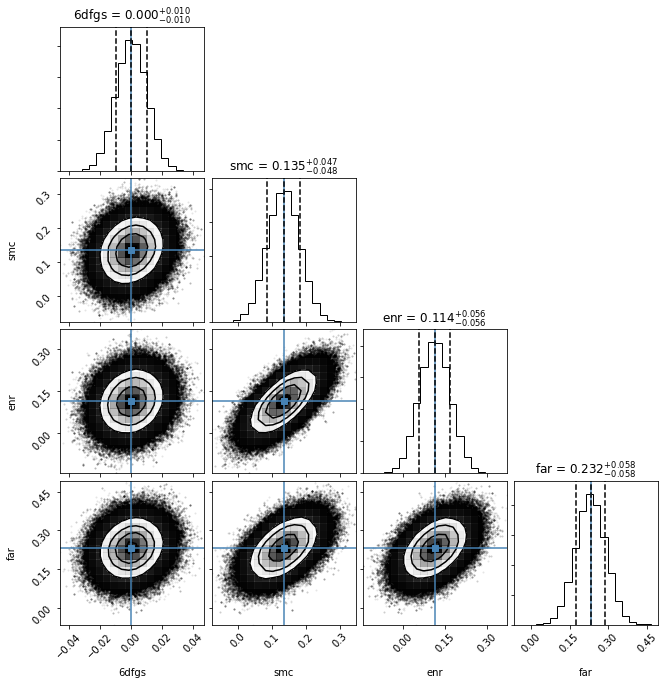

In [16]:
t1 =  datetime.now()
###########################################

ndim, nwalkers = len(catalogs), 128

p0 = [np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

sampler.reset()
sampler.run_mcmc(p0, 10000)
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))

theta = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                            zip(*np.percentile(samples, 
                            [16, 50, 84],
                            axis=0)))

truths=[t[0] for t in theta]
fig = corner.corner(samples, labels=catalogs, 
                    truths=truths, 
                    quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, 
                    title_kwargs={"fontsize": 12}, 
                    title_fmt=".3f")

###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

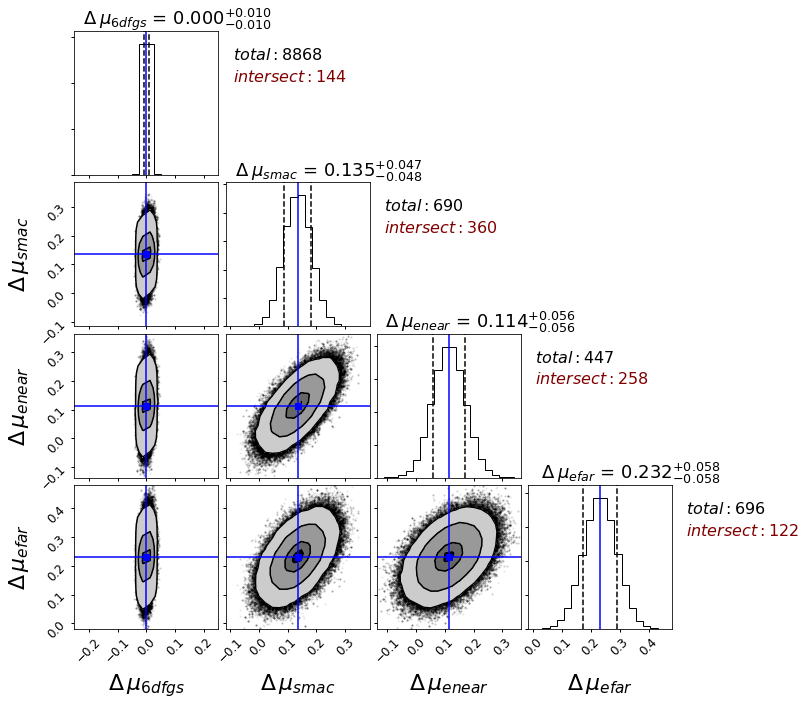

In [17]:
theta = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                            zip(*np.percentile(samples, 
                            [16, 50, 84],
                            axis=0)))

truths=[t[0] for t in theta]

labels = ['           '+r'$\Delta\/ \mu_{'+cat+'}$' for cat in ["6dfgs", "smac", "enear", "efar"]]

fig = corner.corner(samples, labels=labels, 
                    truths=truths, truth_color='blue',
                    levels=(1-np.exp(-1./8),1-np.exp(-0.5),1-np.exp(-0.5*4),1-np.exp(-0.5*9)),
                    show_titles=True, fill_contours=True, plot_density=True,
                    quantiles=[0.16, 0.84], 
                    scale_hist=False,space=0, 
                    title_kwargs={"fontsize": 18}, 
                    title_fmt=".3f",
                    range=[(t-0.25,t+0.25) for t in truths]
                   )


m = 0 
n_cat = len(catalogs)
i_cat = 0
for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=12)
    
    lbl = ax.xaxis.get_label()
    lbl.set_fontsize(22)
    txt = lbl.get_text().strip()
    lbl.set_text(txt)
    lbl.set_linespacing(50)
    lbl = ax.yaxis.get_label()
    lbl.set_fontsize(22)
    txt = lbl.get_text().strip()
    lbl.set_text(txt)    
    
    
    ax.tick_params(which='major', length=3, width=1., direction='out')
    
    Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
    x0 = -0.1*Xlm[0]+1.1*Xlm[1]
    
    if m%(n_cat+1)==0:
        y0 = 0.2*Ylm[0]+0.80*Ylm[1]
        dx = df[['DM_'+catalogs[i_cat]]].dropna()
        ax.text(x0,y0, r"$total: $"+str(len(dx)), fontsize=16, color='k')
        
        y0 = 0.35*Ylm[0]+0.65*Ylm[1]
        other_DMs = ["DM_"+c for c in catalogs if c != catalogs[i_cat]]
        
        df["sumDM"] = df[other_DMs].sum(axis=1)
        df["sumDM"][df["sumDM"]==0] = np.nan
        
        dx = df[['sumDM', 'DM_'+catalogs[i_cat]]].dropna()       
        ax.text(x0,y0, r"$intersect: $"+str(len(dx)), fontsize=16, color='maroon')
        i_cat += 1


    m+=1

